In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('sorted_energy_data .csv', parse_dates=['Datetime'], index_col='Datetime')
data = data.sort_index()  # Ensure the data is sorted by datetime
print(data.head(10))  # Display first 10 rows to check data
df = data

                      NI_MW
Datetime                   
2004-05-01 01:00:00  9198.0
2004-05-01 02:00:00  8570.0
2004-05-01 03:00:00  8183.0
2004-05-01 04:00:00  7917.0
2004-05-01 05:00:00  7828.0
2004-05-01 06:00:00  7806.0
2004-05-01 07:00:00  8082.0
2004-05-01 08:00:00  8267.0
2004-05-01 09:00:00  8830.0
2004-05-01 10:00:00  9381.0


In [ ]:
import numpy as np
import pandas as pd
import sklearn.preprocessing

# Normalize Data (Min-Max Scaling)
def normalize_data(df):
    if 'NI_MW' not in df.columns:
        raise KeyError("Column 'NI_MW' not found in DataFrame")

    df = df.copy()  # Avoid chained assignment warnings
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['NI_MW'] = scaler.fit_transform(df[['NI_MW']])  # Ensure proper scaling
    return df, scaler

df_norm, scaler = normalize_data(df)  # Normalize the dataset

# Function to create sequences for LSTM
def load_data(stock, seq_len):
    X_data, y_data = [], []
    stock_values = stock['NI_MW'].values  # Extract values beforehand

    for i in range(seq_len, len(stock_values)):
        X_data.append(stock_values[i-seq_len:i])  # Creating sequences for X
        y_data.append(stock_values[i])  # Corresponding y values

    return np.array(X_data), np.array(y_data)

# Calculate the index for the 80% split
train_size = int(len(df_norm) * 0.8)
test_size = len(df_norm) - train_size

# Split the data into training and test sets (80% training, 20% testing)
train_data = df_norm.iloc[:train_size]
test_data = df_norm.iloc[train_size:]

# Ensure test_data has enough samples for at least one sequence
if len(test_data) < 24:
    raise ValueError("Test dataset is too small to create sequences")

# Create sequences for training and testing
seq_len = 24  # Sequence length for LSTM
X_train, y_train = load_data(train_data, seq_len)
X_test, y_test = load_data(test_data, seq_len)

# Create a validation set by splitting the training data (e.g., 80% for training, 20% for validation)
val_size = int(len(X_train) * 0.2)
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train, y_train = X_train[:-val_size], y_train[:-val_size]

# Reshape data to be used by LSTM (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_val.shape = ', X_val.shape)
print('y_val.shape = ', y_val.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)


X_train.shape =  (37389, 24, 1)
y_train.shape =  (37389,)
X_val.shape =  (9347, 24, 1)
y_val.shape =  (9347,)
X_test.shape =  (11666, 24, 1)
y_test.shape =  (11666,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN-GRU model architecture
def create_cnn_gru_model(input_shape):
    model = Sequential()

    # CNN Layers: Feature extraction
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # GRU Layers: Sequential learning
    model.add(GRU(units=50, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))

    model.add(GRU(units=50, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))

    # Fully Connected Output Layer
    model.add(Dense(units=1))  # Predict next value

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Define input shape based on the data (samples, time_steps, features)
input_shape = (X_train.shape[1], 1)  # (sequence_length, features)

# Create the CNN-GRU model
cnn_gru_model = create_cnn_gru_model(input_shape)

# Summarize the model to view the architecture
cnn_gru_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 22, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 9, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 4, 50)               │          27,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,311 (262.93 KB)

 Trainable params: 67,311 (262.93 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
import math
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Define early stopping to stop training if val_loss doesn't improve for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Compile the CNN-GRU model using Adam optimizer
cnn_gru_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Standard Adam settings
    loss='mean_squared_error'
)

# Train the CNN-GRU model with early stopping
history = cnn_gru_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,  # Keeping batch size as 64
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks=[early_stopping]  # Apply early stopping
)

# Evaluate the model
test_loss = cnn_gru_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss (MSE): {test_loss}')


Epoch 1/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0132 - val_loss: 0.0038
Epoch 2/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 3/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 4/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 5/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 10/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 11/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 12/100
585/585 ━━━━━━━━━━━━━

In [ ]:
# Save the trained mode
cnn_gru_model.save("CNN_gru_model_100.h5")  # Saves the model in HDF5 format
print("Model saved successfully!")

Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the saved model
model = load_model("CNN_gru_model_100.h5")
print("Model loaded successfully!")

# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss (MSE): {test_loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions if data was normalized
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_actual_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
rmse = math.sqrt(mean_squared_error(y_test_actual_rescaled, predictions_rescaled))
mae = mean_absolute_error(y_test_actual_rescaled, predictions_rescaled)
r2 = r2_score(y_test_actual_rescaled, predictions_rescaled)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared Score (R²): {r2}')


Model loaded successfully!
Test Loss (MSE): 0.001622919226065278
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Root Mean Squared Error (RMSE): 669.866724265077
Mean Absolute Error (MAE): 507.7714721114644
R-squared Score (R²): 0.9196029279568722


365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Test Loss (MSE): 448721.4283
Root Mean Squared Error (RMSE): 669.8667
Mean Absolute Error (MAE): 507.7715
R² Score: 0.9196
Mean Absolute Percentage Error (MAPE): 4.42%
Regression Accuracy (within 10% error): 91.57%


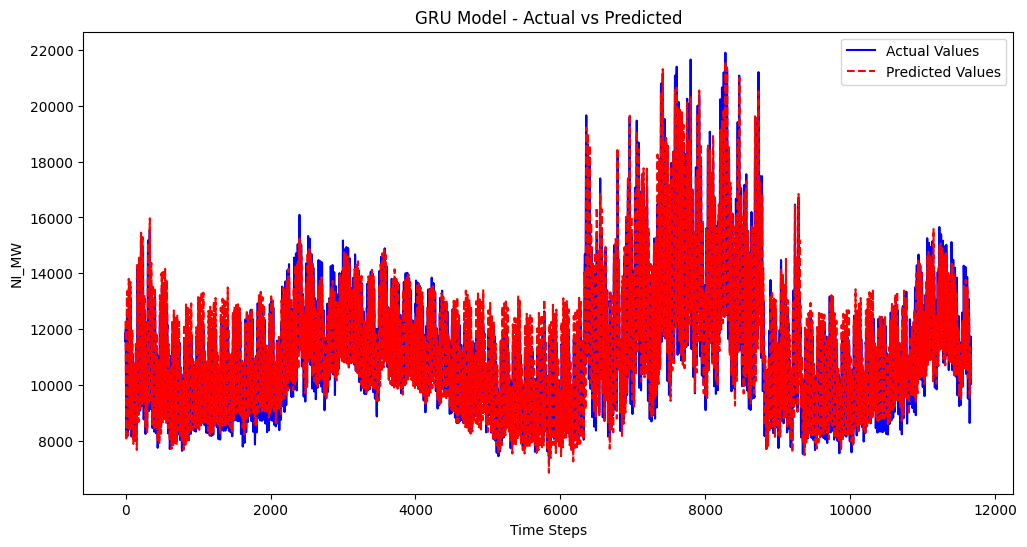

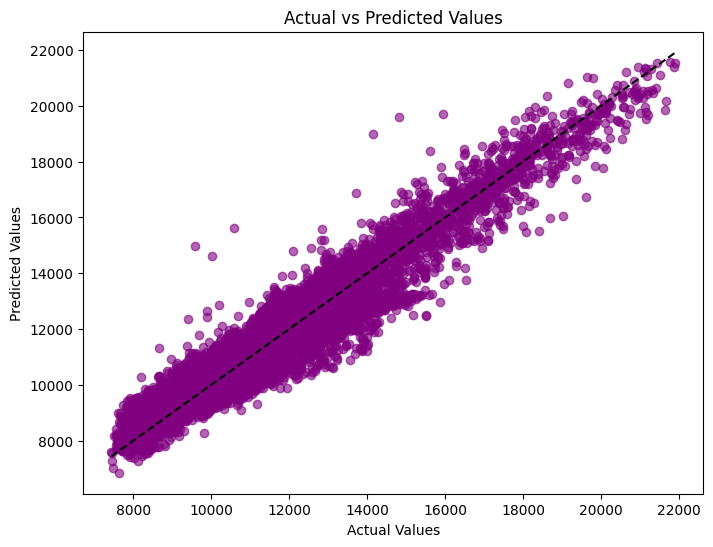

In [ ]:
 import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the saved model
gru_model = load_model('CNN_gru_model_100.h5')  # Change filename if needed

# Make predictions on the test set
gru_predictions = gru_model.predict(X_test)

# Inverse transform predictions (if data was normalized)
gru_predictions_rescaled = scaler.inverse_transform(gru_predictions)
y_test_actual_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute evaluation metrics
mse = mean_squared_error(y_test_actual_rescaled, gru_predictions_rescaled)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_actual_rescaled, gru_predictions_rescaled)
r2 = r2_score(y_test_actual_rescaled, gru_predictions_rescaled)

# Compute Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_actual_rescaled - gru_predictions_rescaled) / y_test_actual_rescaled)) * 100

# Compute Regression Accuracy (within 10% error margin)
threshold = 0.10  # 10% error tolerance
accuracy = np.mean(np.abs((y_test_actual_rescaled - gru_predictions_rescaled) / y_test_actual_rescaled) < threshold) * 100

# Print the evaluation metrics
print(f'Test Loss (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Regression Accuracy (within 10% error): {accuracy:.2f}%')

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_rescaled, label='Actual Values', color='blue')
plt.plot(gru_predictions_rescaled, label='Predicted Values', color='red', linestyle='dashed')
plt.title('GRU Model - Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('NI_MW')
plt.legend()
plt.show()

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual_rescaled, gru_predictions_rescaled, color='purple', alpha=0.6)
plt.plot([min(y_test_actual_rescaled), max(y_test_actual_rescaled)],
         [min(y_test_actual_rescaled), max(y_test_actual_rescaled)], color='black', linestyle='dashed')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


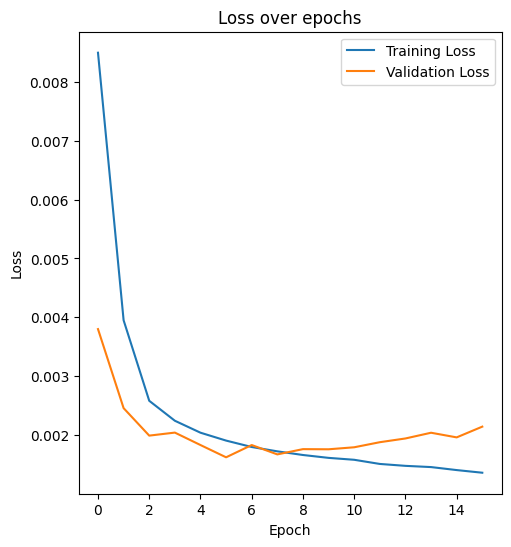

In [ ]:
# Optionally, you can visualize the loss and accuracy over epochs
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.show()


## **CNN + LSTM**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN-LSTM model architecture
def create_cnn_lstm_model(input_shape):
    model = Sequential()

    # CNN Layers: Feature extraction
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # LSTM Layers: Sequential learning
    model.add(LSTM(units=50, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))

    # Fully Connected Output Layer
    model.add(Dense(units=1))  # Predict next value

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Define input shape based on the data (samples, time_steps, features)
input_shape = (X_train.shape[1], 1)  # (sequence_length, features)

# Create the CNN-LSTM model
cnn_lstm_model = create_cnn_lstm_model(input_shape)

# Summarize the model to view the architecture
cnn_lstm_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 22, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 9, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 4, 50)               │          35,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,011 (316.45 KB)

 Trainable params: 81,011 (316.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
import math
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Define early stopping to stop training if val_loss doesn't improve for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Compile the CNN-LSTM model using Adam optimizer
cnn_lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

# Train the CNN-LSTM model with early stopping
history = cnn_lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks=[early_stopping]  # Apply early stopping
)

# Evaluate the model
test_loss = cnn_lstm_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss (MSE): {test_loss}')


Epoch 1/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0140 - val_loss: 0.0042
Epoch 2/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 3/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 4/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 5/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 6/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 7/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 8/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 11/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 12/100
585/585 ━━━━━━━━━━━━━

In [ ]:
# Save the trained mode
cnn_lstm_model.save("CNN_lstm_model_100.h5")  # Saves the model in HDF5 format
print("Model saved successfully!")

Model saved successfully!


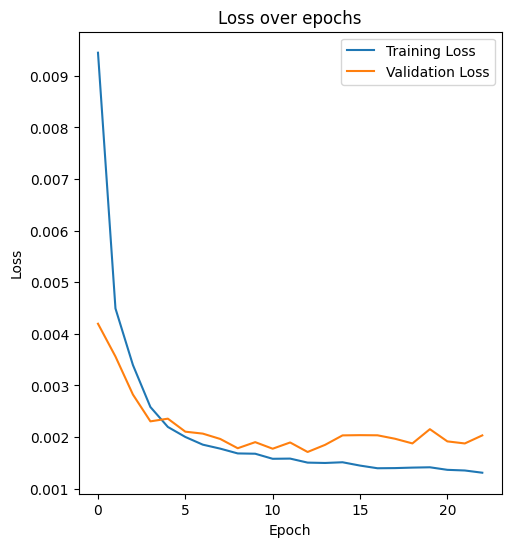

In [ ]:
# Optionally, you can visualize the loss and accuracy over epochs
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.show()


365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Loss (MSE): 472858.3649
Root Mean Squared Error (RMSE): 687.6470
Mean Absolute Error (MAE): 516.2894
R² Score: 0.9153
Mean Absolute Percentage Error (MAPE): 4.45%
Regression Accuracy (within 10% error): 91.43%


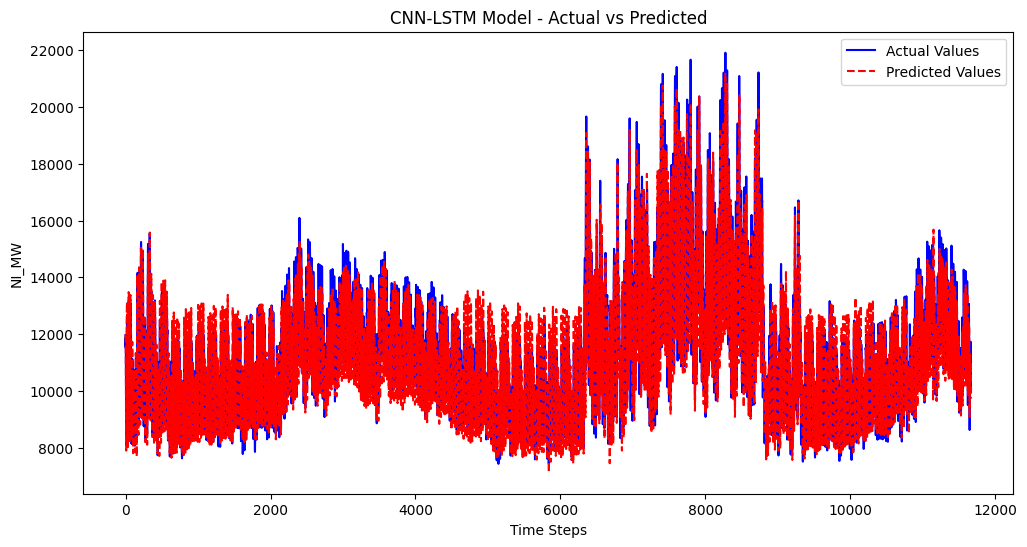

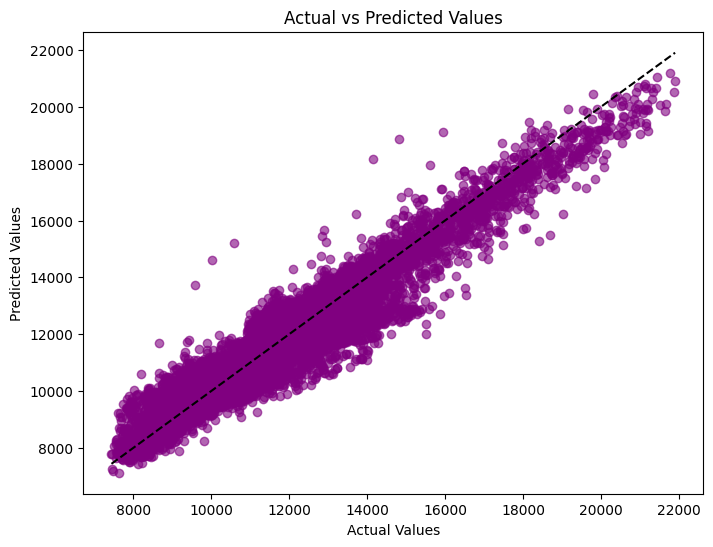

In [ ]:
 import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the saved model
gru_model = load_model('CNN_lstm_model_100.h5')  # Change filename if needed

# Make predictions on the test set
gru_predictions = gru_model.predict(X_test)

# Inverse transform predictions (if data was normalized)
gru_predictions_rescaled = scaler.inverse_transform(gru_predictions)
y_test_actual_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute evaluation metrics
mse = mean_squared_error(y_test_actual_rescaled, gru_predictions_rescaled)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_actual_rescaled, gru_predictions_rescaled)
r2 = r2_score(y_test_actual_rescaled, gru_predictions_rescaled)

# Compute Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_actual_rescaled - gru_predictions_rescaled) / y_test_actual_rescaled)) * 100

# Compute Regression Accuracy (within 10% error margin)
threshold = 0.10  # 10% error tolerance
accuracy = np.mean(np.abs((y_test_actual_rescaled - gru_predictions_rescaled) / y_test_actual_rescaled) < threshold) * 100

# Print the evaluation metrics
print(f'Test Loss (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Regression Accuracy (within 10% error): {accuracy:.2f}%')

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_rescaled, label='Actual Values', color='blue')
plt.plot(gru_predictions_rescaled, label='Predicted Values', color='red', linestyle='dashed')
plt.title('CNN-LSTM Model - Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('NI_MW')
plt.legend()
plt.show()

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual_rescaled, gru_predictions_rescaled, color='purple', alpha=0.6)
plt.plot([min(y_test_actual_rescaled), max(y_test_actual_rescaled)],
         [min(y_test_actual_rescaled), max(y_test_actual_rescaled)], color='black', linestyle='dashed')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()
